In [1]:
# Загружаем библиотеки для дальнейшей нашей работы.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
# Записываем датасет в переменную и смотрим структуру данных
data = pd.read_csv('ghana_gdp.csv',index_col=['year'],parse_dates=['year'])
display(data.head(3))
data.shape

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09


(62, 1)

# <center> Визуализация данных

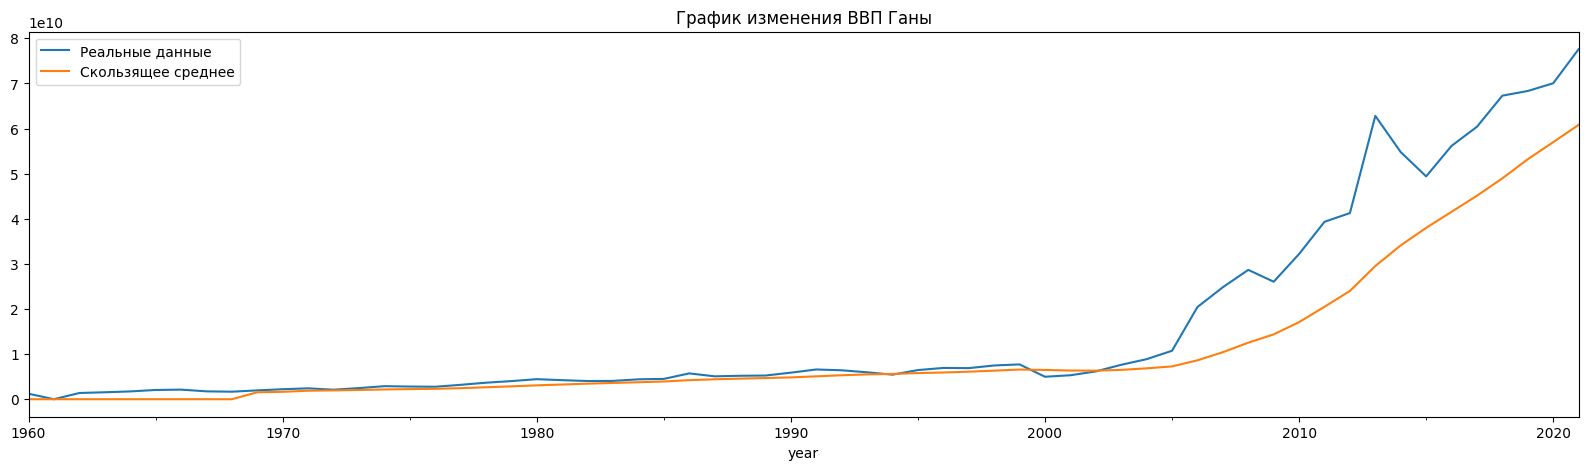

In [3]:
# Визуализируем наши данные.
fig,ax = plt.subplots(figsize=(20,5))
data.plot(ax=ax)
data.rolling(10).mean().fillna(0.6).plot(ax=ax)
plt.legend(['Реальные данные','Скользящее среднее'])
plt.title('График изменения ВВП Ганы')
plt.show()


На графике отлично виден тренд в данных и отсутствие какой либо сезонности или цикличности. Скользящее среднее я взял 10, что бы увидеть тренд, убрав колебания показателя ВВП во времени. Разделим наши данные на тренировочную и тестовую выборки, взяв в последнее три крайних года.

In [4]:
X_train = data.iloc[:-3]
X_test = data.iloc[-3:]

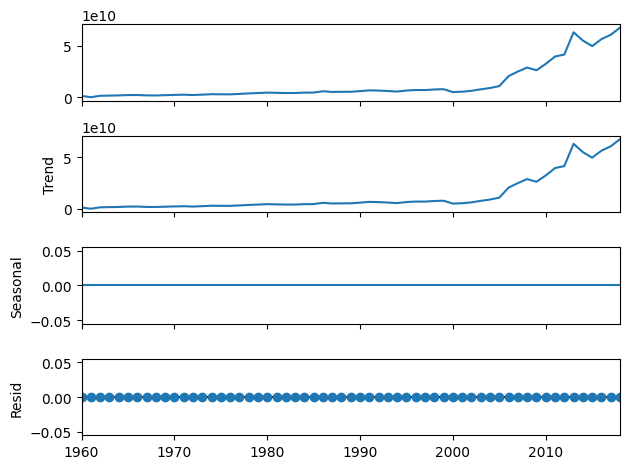

In [5]:
# Построим декомпозицию
ds = seasonal_decompose(X_train)
ds.plot()
plt.show()

Как и было ранее предположено:
* Есть тренд
* Отсутствие сезонности
* Разброс ошибок ровный



# <center> Оценка стационарности данных

In [6]:
test = adfuller(X_train)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('ряд НЕстационарен')
else:
    print ('ряд стационарен')

adf:  0.65290669748854
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд НЕстационарен


Видим, что ряд нестационарный, это означает, что нам необходимо понять, на сколько нам надо дифференцировать временной ряд, что бы он был стационарным. Для этого напишем функцию, где нам будет показано, сколько раз мы дифференцировали данные.

In [7]:
def func_diff(data):
    n = 0
    tst = adfuller(data)
    if tst[0] <= tst[4]['5%']:
        return print('количество дифференцирований:', n)
    
    else : 
        data = data.diff().dropna()
        for i in range(10):
            n += 1
            test = adfuller(data)
            if test[0] <= test[4]['5%']:
                return print('количество дифференцирований:',n)
                
            else:
                data = data.diff().dropna()
                continue
func_diff(X_train)             

количество дифференцирований: 3


Итак мы выяснили, чтобы наш ряд был стационарным, нам надо 3 раза дифференцировать.

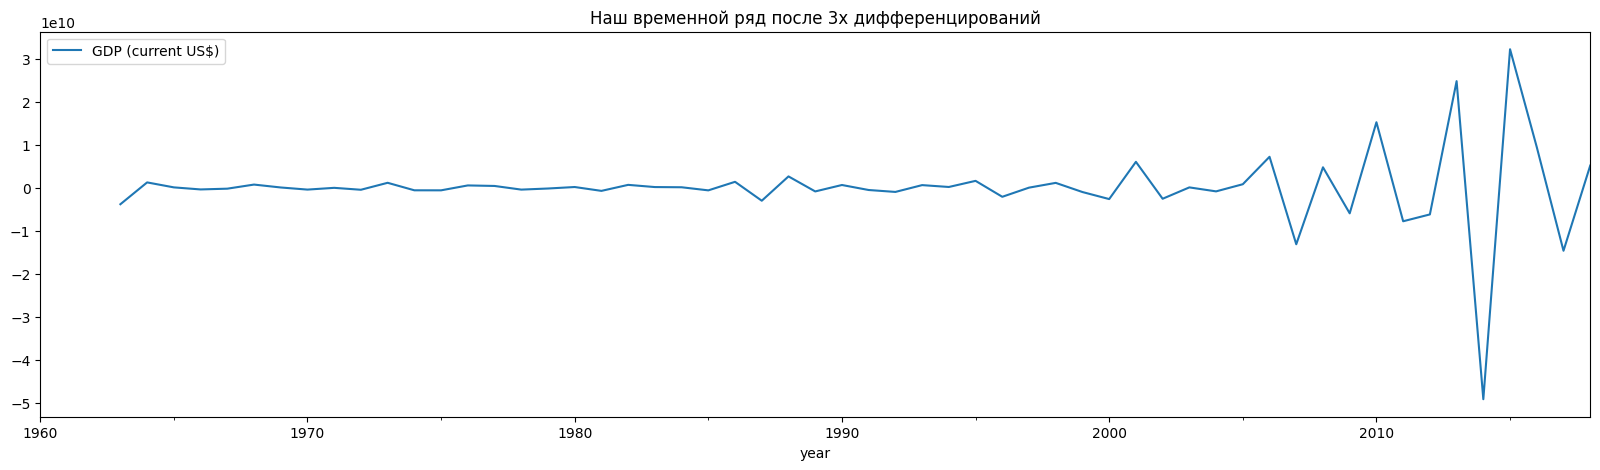

In [8]:
X_train.diff().diff().diff().plot(figsize=(20,5));
plt.title('Наш временной ряд после 3х дифференцирований')
plt.show()

Теперь наши данные не имеют сезонности и отсутствует тренд, как было это ранее. Отрисуем коррелограммы для дальнейшего принятия решения при поиске p,q коэффициентов.

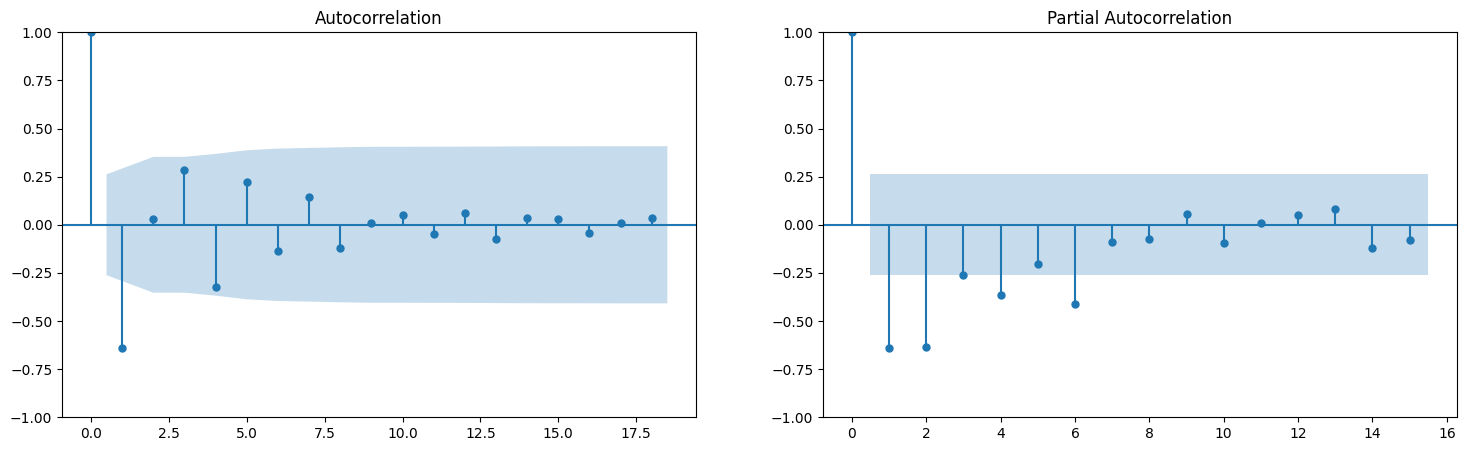

(-4.779623784828548,
 5.948327640224507e-05,
 7,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2060.4811556595264)

In [9]:
import statsmodels.graphics.tsaplots as sgt
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0])
    sgt.plot_pacf(series, ax=axes[1],lags=15)
    plt.show()
plot_acf_pacf(X_train.diff().diff().diff().dropna())
adfuller(X_train.diff().diff().diff().dropna())    

Так же по коррелограмме видно, что первый лаг самый большой по значению, а это так же подтверждает наличие только тренда.

В действительности, 3-ая разность является стационарной. Коэффициенты p,d,q в итоге мы возьмем следующие.
* p - 2
* d - 3
* q - 1

# <center> Моделирование

Так как у нас ряд изначально был не стационарным и при этом отсутствует сезонность и внешние какие-либо факторы, то можно выбирать модель ARIMA.

In [10]:
from statsmodels.tsa.arima.model import ARIMA
Arima_model_0 = ARIMA(X_train,order=(2,3,1))
Arima_fit_0 = Arima_model_0.fit()
Arima_fit_0.summary()
pred_Arima_0 = Arima_fit_0.predict(start=len(X_train), end=(len(data)-1), dynamic=False)
display(pred_Arima_0)
print('AIC метрика: ',round(Arima_fit_0.aic))

/home/roman/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/roman/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/roman/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


2019-01-01    7.368591e+10
2020-01-01    7.954567e+10
2021-01-01    8.633936e+10
Freq: AS-JAN, Name: predicted_mean, dtype: float64

AIC метрика:  2659


Теперь подберем наши p,d,q коэффиенты через функцию auto_arima

In [11]:
import pmdarima as pm
Arima_best_0 = pm.auto_arima(
    X_train,
    start_p=1,
    start_q=1,
    d=3,
    max_p=4,
    max_q=4,
    seasonal=False,
    information_criterion='aic',
    error_action="ignore",
    trace=True)
pred_best_0 = Arima_best_0.predict(3)
pred_best_0


Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.08 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.06 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.09 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.04 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.16 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.84 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.07 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=1.24 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.12 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 3.312 seconds


2019-01-01    7.368591e+10
2020-01-01    7.954567e+10
2021-01-01    8.633936e+10
Freq: AS-JAN, dtype: float64

Решил проверить, действительно ли самый низкий показатель метрики AIC будет принадлежать моим иследованиям. Видим, что при уровне разности равным 3, значения коэф. p и q соответствуют моим, но при этом есть ощущение, что это не самый точный прогноз. Проверим на модели, где значение d стоит по умолчанию 2.

In [12]:
import pmdarima as pm
Arima_best_1 = pm.auto_arima(
    X_train,
    start_p=1,
    start_q=1,
    max_p=4,
    max_q=4,
    seasonal=False,
    information_criterion='aic',
    error_action="ignore",
    trace=True)
pred_best_1 = Arima_best_1.predict(3)
pred_best_1

Performing stepwise search to minimize aic


 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.60 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.23 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.079, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]  

2019-01-01    6.789080e+10
2020-01-01    7.253326e+10
2021-01-01    7.517348e+10
Freq: AS-JAN, dtype: float64

Увы, но при уровне разности равным 2, модель показывает более точные предсказания.
Заметил очень важную деталь, при небольшом датасете не стоит повышать разность выше двух, как это стоит по умолчанию в auto_arima, т.к. теряются данные. У нас всего чуть более 60 наблюдений. При каждой разнице мы удаляем важную информацию. Я попробовал и 3,7,10 уровень разности, при этом метрика AIC увеличивается, а предсказания становятся все более не точные. У меня по моим данным значение d должно быть 3, при этом метрика 2659, а если значение d оставить по умолчанию в функции auto_arima, прогноз более точный.

In [13]:
# Обучим нашу модель на лучших параметрах
Arima_final_model = ARIMA(X_train,order=(1,2,3))
Arima_final_fit = Arima_final_model.fit()

/home/roman/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/roman/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/roman/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/roman/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Визуализируем наши предсказания на графике + добавим доверительный интервал к нему.

In [14]:
# Создадим датасет с предсказанными данными и доверительным интервалом.
pred_df = pd.DataFrame(index=data.index)
pred_df["model_preds"] = Arima_final_fit.predict(start=len(X_train),end=len(data)-1)
pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = Arima_final_fit.get_forecast(len(X_test.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[X_test.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[X_test.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

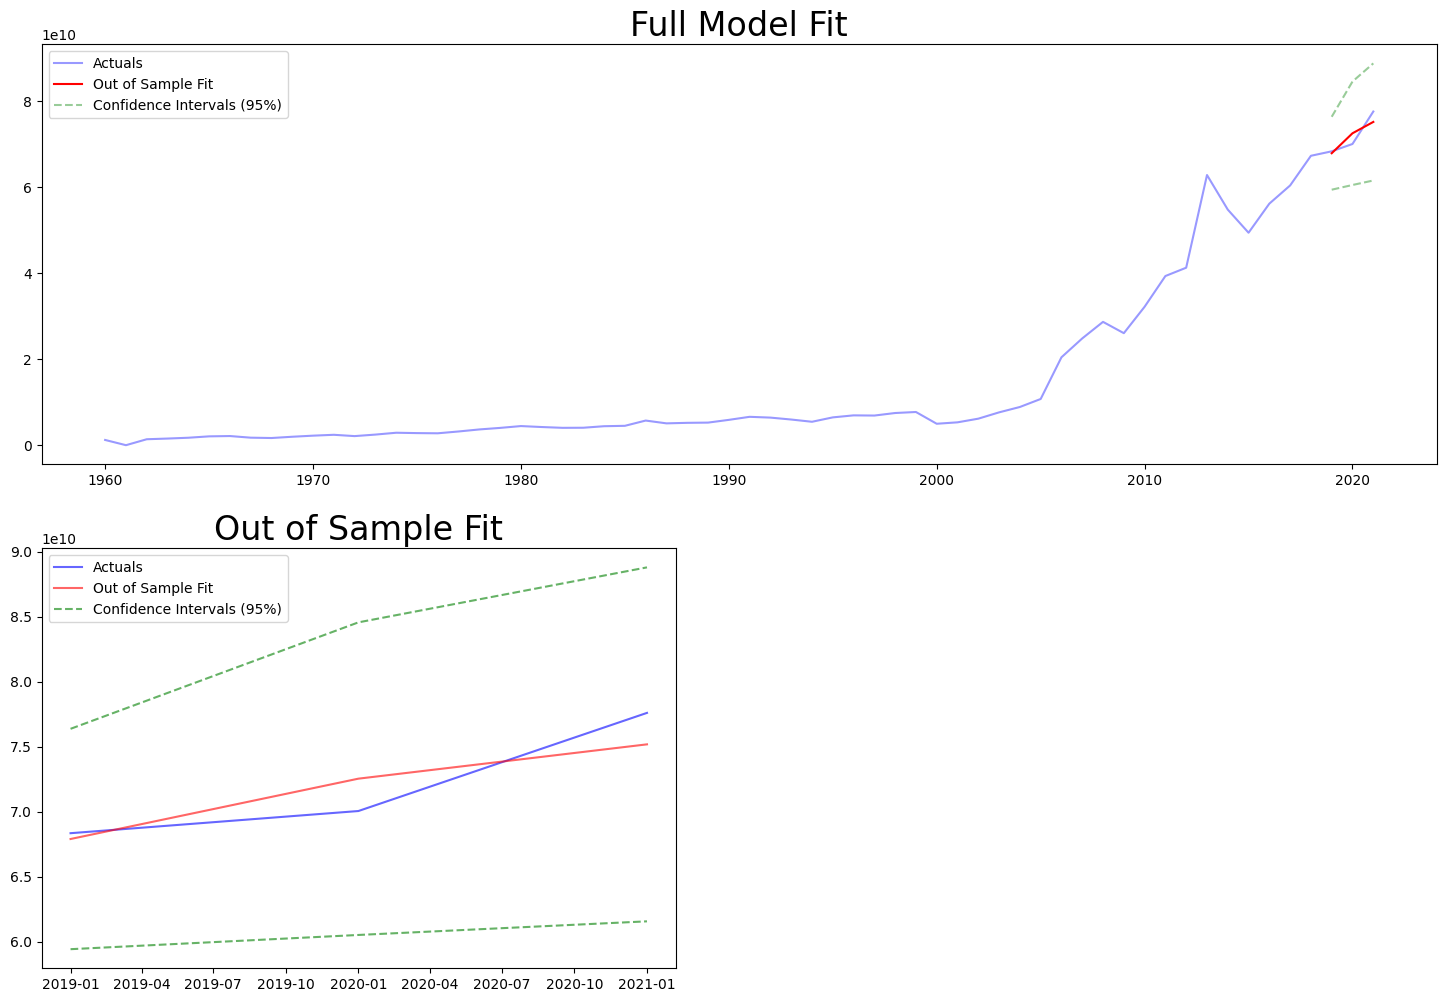

In [15]:
# Отрисуем график
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[X_test.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[X_test.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[X_test.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[X_test.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[X_test.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[X_test.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[X_test.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

На нашем графике видно, что все значения и предсказанные и реальные лежат в пределах 95% доверительного интервала. 

# <center> Downsampling / Upsampling (Интерполяция)

Проверим датафрейм на пропущенные даты.

In [16]:
print('Количество пропусков данных в датасете :', data.asfreq(freq='YS').isna().sum())

Количество пропусков данных в датасете : GDP (current US$)    0
dtype: int64


Временной ряд должен содержать одиннаковый период. Мы проверили наличие пропусков в данных с периодом начала года.

In [17]:
# Теперь заменим нулевые значения в нашем датасете на значение Nan
data_interpolate = data.copy()
data_interpolate["GDP (current US$)"] = data["GDP (current US$)"].apply(lambda x: np.nan if x==0 else x)


In [18]:
# Заменим наши пропущенные данные с помощью интерполяции.
data_interpolate = data_interpolate.interpolate(method='linear')

In [19]:
# Снова разделим наши данные на тренировочные и тестовые
X_train_interpolate = data_interpolate['GDP (current US$)'][:-3]
X_test_interpolate = data_interpolate['GDP (current US$)'][-3:]

## Стационарность данных

In [20]:
test_2 = adfuller(X_train_interpolate)
print ('adf: ', test_2[0])
print ('p-value: ', test_2[1])
print ('Critical values: ', test_2[4])
if test_2[0]> test_2[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  0.8030073326980106
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


## Моделирование

Т.к. данные у нас остались не стационарными воспользуемся моделью ARIMA, для этого возьмем функцию для автоматического подбора нужных параметров auto_arima

In [21]:
Arima_best_2 = pm.auto_arima(
    X_train_interpolate,
    start_p=1,
    start_q=1,
    max_p=4,
    max_q=4,
    seasonal=False,
    information_criterion='aic',
    error_action="ignore",
    trace=True)
pred_best_2 = Arima_best_1.predict(3)
pred_best_2

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.07 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.04 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

2019-01-01    6.789080e+10
2020-01-01    7.253326e+10
2021-01-01    7.517348e+10
Freq: AS-JAN, dtype: float64

Результат практически не изменился, разница составила сотые доли. Это связано с тем, что данных, которые мы заменили интерполяций, мало, всего одно значение, при том, что оно было в начале временного ряда и особой роли для ряда не играет.

# <center> Волатильность

 **Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

In [22]:
# создадим новый столбец с волатильностью
data_interpolate["vol GDP (current US$)"] = data_interpolate['GDP (current US$)'].pct_change(1).mul(100).abs()
data_interpolate.head()

,GDP (current US$),vol GDP (current US$)
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636


adf:  -6.80733894469635
p-value:  2.1599127900854784e-09
Critical values:  {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}
ряд стационарен


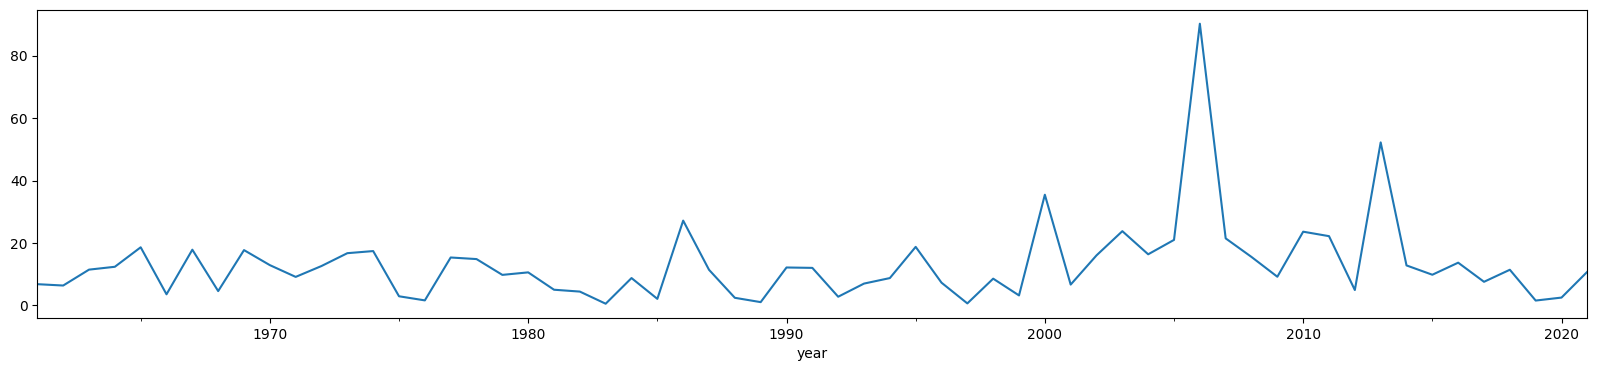

In [23]:
# постоим график
data_interpolate["vol GDP (current US$)"].dropna().plot(figsize=(20,4));
test_3 = adfuller(data_interpolate["vol GDP (current US$)"].dropna())
print ('adf: ', test_3[0])
print ('p-value: ', test_3[1])
print ('Critical values: ', test_3[4])
if test_3[0]> test_3[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

Видно, что наши данные имеют разброс. Но при этом ряд стационарен.

## Автокорреляция

In [24]:
# Разделим наши данные на тренировочные и тестовые
X_train_vol = data_interpolate.iloc[:-3]
X_test_vol = data_interpolate.iloc[-3:]

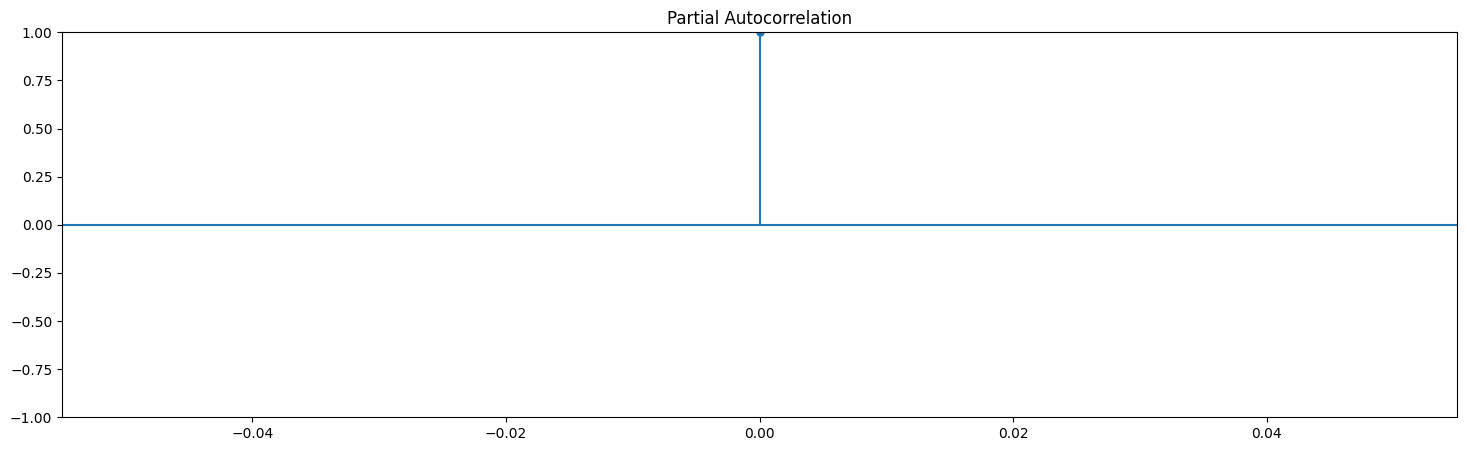

In [25]:
# Частичная автокорреляция для формирования коэффициента p
plt.rcParams["figure.figsize"] = 18, 5
sgt.plot_pacf(X_train_vol['vol GDP (current US$)'],lags=20)
plt.show()

Отсутствие автокорреляции говорит о том, что наши данные невозможно предсказать. Стоит в этом убедиться.

In [26]:
garch_df = data_interpolate['vol GDP (current US$)'].dropna()


In [27]:
from arch import arch_model

model = arch_model(garch_df, p=1, q=3,vol='GARCH')

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=X_test_vol.index[0], update_freq=5)

Iteration:      5,   Func. Count:     38,   Neg. LLF: 227.55048804578533
Iteration:     10,   Func. Count:     73,   Neg. LLF: 226.61710831723255
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.61693560760435
            Iterations: 12
            Function evaluations: 86
            Gradient evaluations: 12


In [28]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Constant Mean - GARCH Model Results                       
=================================================================================
Dep. Variable:     vol GDP (current US$)   R-squared:                       0.000
Mean Model:                Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         GARCH   Log-Likelihood:               -226.617
Distribution:                     Normal   AIC:                           465.234
Method:               Maximum Likelihood   BIC:                           477.597
                                           No. Observations:                   58
Date:                   Sun, Mar 30 2025   Df Residuals:                       57
Time:                           15:26:58   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3499     10.058      1.228      0.219 [ -7.363, 32.063]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         10.5216    391.204  2.690e-02      0.979 [-7.562e+02,7.773e+02]
alpha[1]       0.0000      0.147      0.000      1.000      [ -0.288,  0.288]
beta[1]    1.1347e-10      0.305  3.714e-10      1.000      [ -0.599,  0.599]
beta[2]    4.6449e-11  7.043e-02  6.595e-10      1.000      [ -0.138,  0.138]
beta[3]        1.0000      2.555      0.391      0.695      [ -4.007,  6.007]
=============================================================================

Covariance estimator: robust
"""

In [29]:
predictions_df = X_test_vol.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[X_test_vol.index]
predictions_df 

,GDP (current US$),vol GDP (current US$),Predictions
year,,,
2019-01-01,6.833754e+10,1.542746,278.857514
2020-01-01,7.004320e+10,2.495937,289.379097
2021-01-01,7.759428e+10,10.780603,289.379097


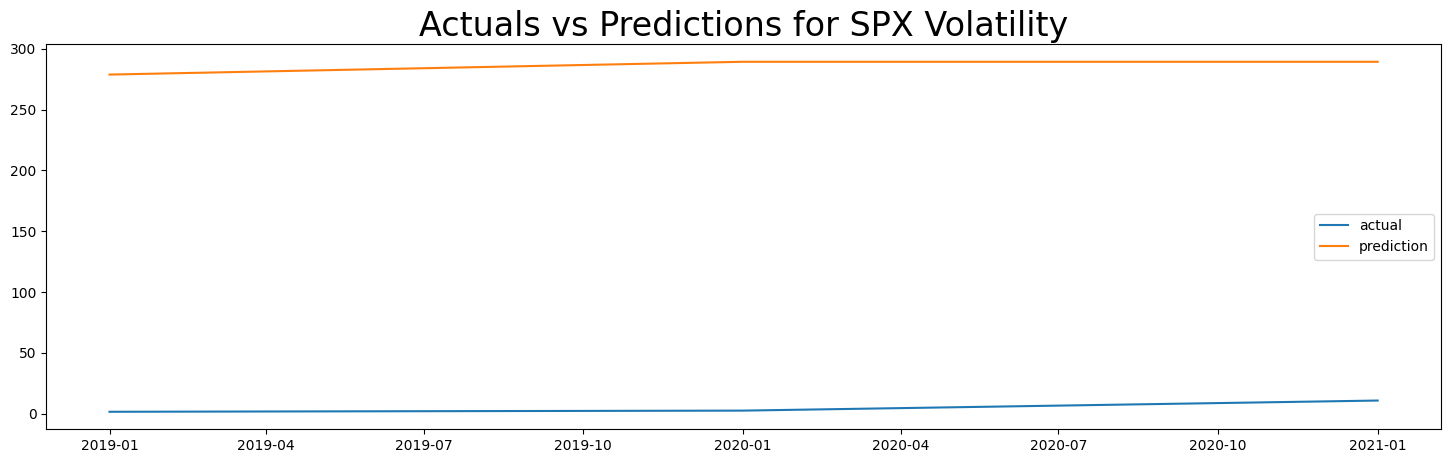

In [30]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["vol GDP (current US$)"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for SPX Volatility", size=24)
plt.legend(['actual','prediction'])
plt.show()

Судя по полученному графику, модель не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке. 

проверим точность на MSE метрике.

In [38]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(predictions_df['vol GDP (current US$)'],predictions_df['Predictions']))

78940.84965110893


В итоге у нас модель оказалась провальной и не смогла уловить никакой зависимости. Ошибка очень большая.

## <center> Линейная регрессия

In [149]:
# разделим наши данные
lmt = X_train_vol.shape[0]
X_train_lr = pd.DataFrame({'col':range(X_train_vol.dropna().shape[0])},index=X_train_vol.dropna().index)
X_test_lr = pd.DataFrame({'col':range(lmt, lmt+X_test_vol.dropna().shape[0])},index=X_test_vol.dropna().index)
y_train_lr = X_train_vol.dropna()['vol GDP (current US$)']


In [150]:
# обучим модель линейной регрессии и сразу сделаем прогноз
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_lr,y_train_lr)
pred = model.predict(X_test_lr)


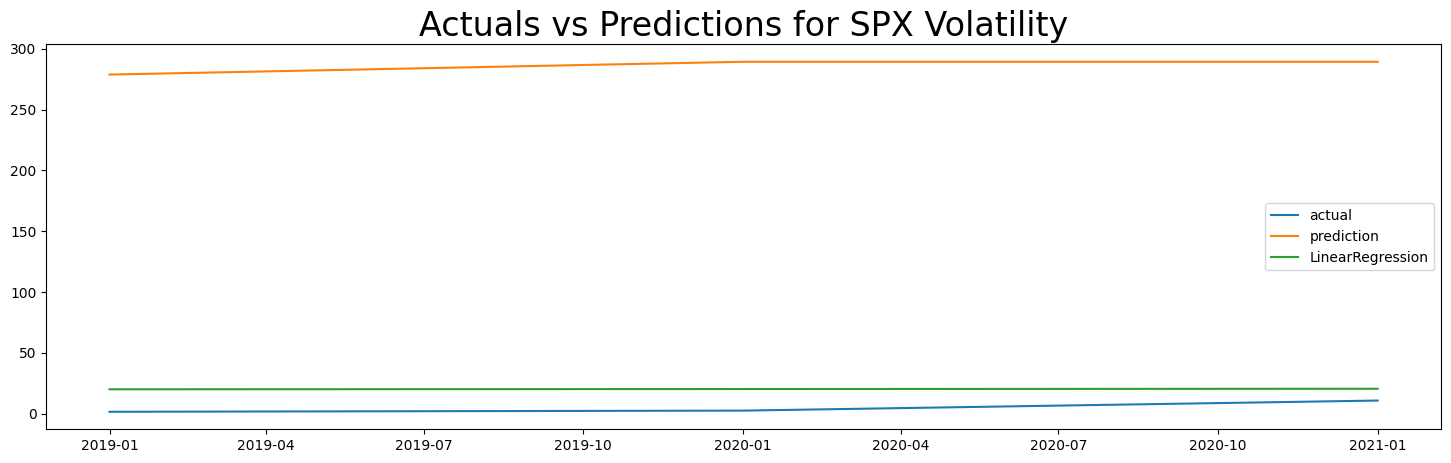

In [151]:
# визуализируем три графика.
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["vol GDP (current US$)"])
plt.plot(predictions_df["Predictions"])
plt.plot(pd.DataFrame(pred,index=X_test.index))

plt.title("Actuals vs Predictions for SPX Volatility", size=24)
plt.legend(['actual','prediction','LinearRegression'])
plt.show()

Подведем итог:
* не всегда можно пользоваться той или иной моделью, необходимо всегда анализировать данные и смотреть на графики.
* в данном случае модель линейной регрессии оказалась более точной в предсказании волатильности. Опять же дело в качестве тренировочных данных, насколько они обширны и имеют в себе различные варианты.